# Simulate, Export Data, and Plot

## Import and Setting the Verbosity Level

We first import the `andes` library and the `get_case` function that for loading test cases shipped with ANDES.

In [1]:
import andes

from andes.utils.paths import get_case

We can configure the verbosity level for logging (output messages) by passing a verbosity level (10-DEBUG, 20-INFO, 30-WARNING, 40-ERROR, 50-CRITICAL) to the `stream_level` argument of `andes.main.config_logger()`. Verbose level 10 is useful for getting debug output.

Once configured, the logging level cannot be altered (in the current version of ANDES) for the current Python session.

In [2]:
andes.main.config_logger(stream_level=20)

If this step is omitted, the default `INFO` level (`stream_level=20`) will be used.

## Run Time-Domain Simulation

### Run power flow by default

`get_case` takes a relative path to `ANDES_ROOT/andes/cases` and returns the full path, where `ANDES_ROOT` is the root folder of ANDES.

`andes.run` is the entrypoint function for loading files and running routines. It runs power flow by default and returns a `System` object.

In [3]:
ss = andes.run(get_case('kundur/kundur_full.xlsx'))

Working directory: "/Users/hcui7/repos/andes/examples"
Loaded config from file "/Users/hcui7/.andes/andes.rc"
Parsing input file "/Users/hcui7/repos/andes/andes/cases/kundur/kundur_full.xlsx"
Input file parsed in 0.0677 seconds.

-> Power flow calculation
Sparse Solver: KLU
Method: NR method
Power flow initialized.
0: |F(x)| = 14.9283   
1: |F(x)| = 3.60858   
2: |F(x)| = 0.17009   
3: |F(x)| = 0.00203822
4: |F(x)| = 3.76399e-07
Converged in 5 iterations in 0.0102 seconds.
Initialization was successful in 0.0195 seconds.
Report saved to "kundur_full_out.txt" in 0.0023 seconds.
-> Single process finished in 0.1907 seconds.


### Run time-domain simulation 
Run TDS by calling `TDS.run()` on the system. Note that the call must follow the power flow immediately.

The default simulation is for 20 seconds. To change if, change ``config.tf`` to the desired value.

In [4]:
ss.TDS.config.tf = 10  # simulate for 10 seconds

In [5]:
ss.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-10 sec.
Fixed step size: h=33.33 msec., shrink if not converged


<Toggler 1>: Line.Line_8 status changed to 0 at t=2.0 sec.            
100%|███████████████████████████████| 100/100 [00:00<00:00, 131.59%/s]

Simulation completed in 0.7603 seconds.
TDS outputs saved in 0.0129 seconds.


True

To check if all operations completed successfully, check `ss.exit_code`. `exit_code == 0` means that all operations were successful. 

If not zero, `exit_code` indicates the number of errors caught. One will need to check output messages for errors.

In [6]:
ss.exit_code

0

## Export and Plot Results

If you are using ANDES interactively from Jupyter Notebook or IPython, at the end of a time-domain simulation. a plotter object `ss.TDS.plt` will automatically be created.

To check if that has been created successfully (in case the detection of an interactive environment fails), check the type of `ss.TDS.plt`.

In [7]:
ss.TDS.plt

If `ss.TDS.plt` is None, it can be manually loaded with `ss.TDS.load_plotter()`. Otherwise, `load_plotter()` can be safely skipped.

In [8]:
ss.TDS.load_plotter()

### Exporting simulation data to csv

To export simulation results to a CSV file, one can use `ss.TDS.plt.export_csv()`, which takes an optional argument of the file name. 

If not provided, a default file name will be assigned.

In [9]:
ss.TDS.plt.export_csv()

CSV data saved to "/Users/hcui7/repos/andes/examples/kundur_full_out.csv".


### Index-based Plotting

`plotter.plot()` is the entry point for plotting. It is the backend of the command-line `andes plot`. 


Before plotting, open the `kundur_full_out.lst` to find the indices (first column) for the variables to plot.

For example, if we want to plot all generator speed, which is the `omega` variable of `GENROU`. 
By inspect, we found the indices as `5, 6, 7, 8`. 

Pass them in a tuple or a list to `ss.TDS.plt.plot`.

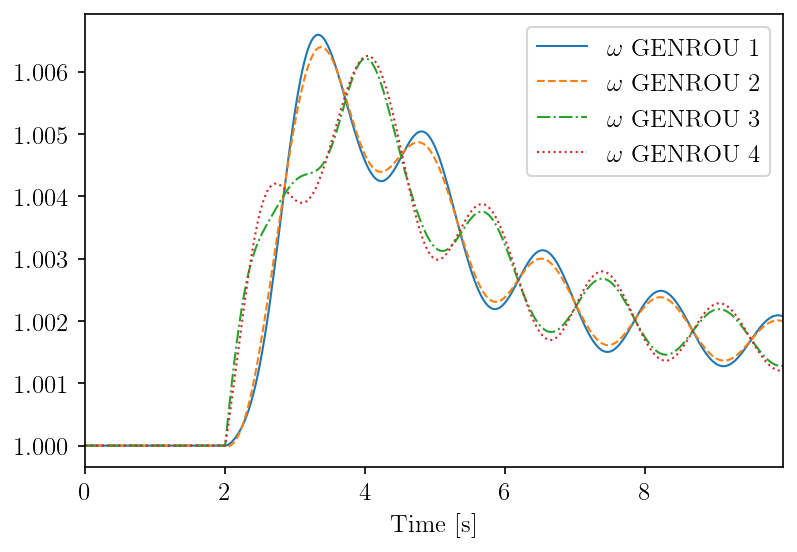

In [10]:
fig, ax = ss.TDS.plt.plot((5, 6, 7, 8))

### Find index by variable name

`plotter.find()` is a method for finding indices based on variable name.

The first argument is the pattern to find. An optional argument `exclude` is the pattern to exclude. Regular expression is supported for both.

In [20]:
ss.TDS.plt.find('omega')

([5, 6, 7, 8],
 ['omega GENROU 1', 'omega GENROU 2', 'omega GENROU 3', 'omega GENROU 4'])

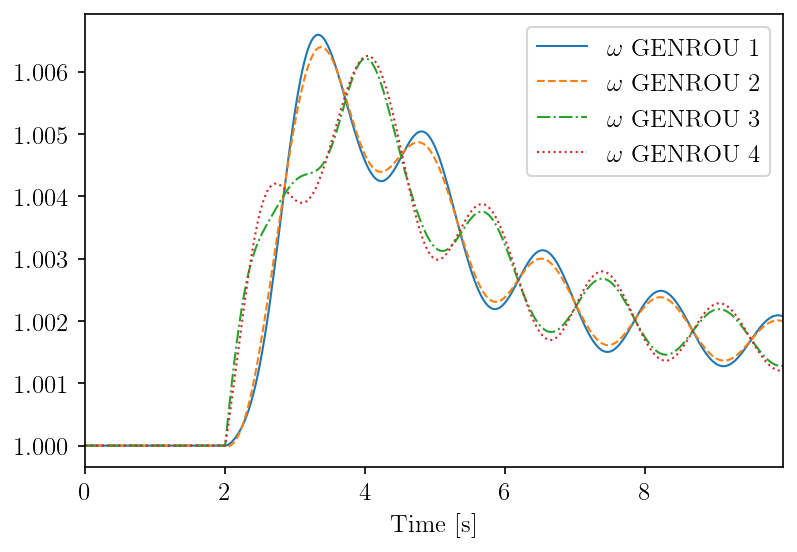

In [7]:
fig, ax = ss.TDS.plotter.plot(ss.TDS.plotter.find('omega')[0])

### Plotting by variable

Looking up indices from the `lst` file can be tedious. 

Instead, one can pass a a variable in a model to `ss.TDS.plt.plot`. For example, to plot `ss.GENROU.omega`, do

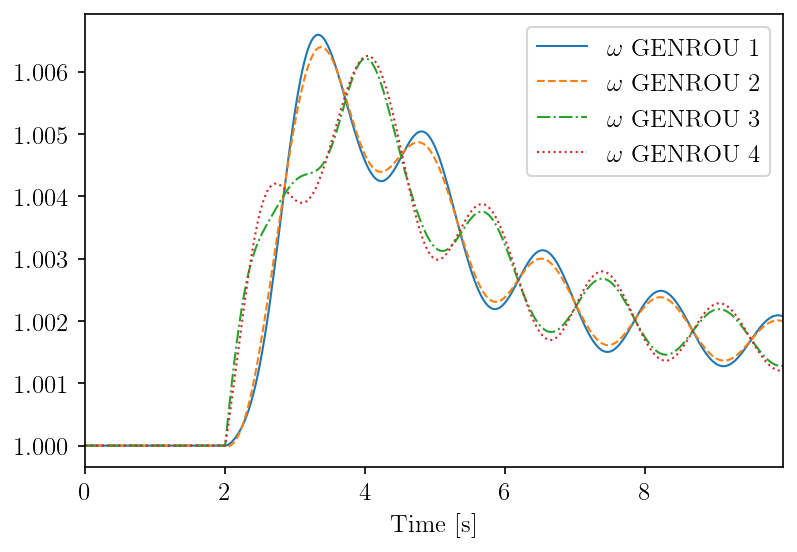

(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbef62dc550>)

In [9]:
ss.TDS.plt.plot(ss.GENROU.omega)

To plot a subset of the variables, pass the 0-indexed selection indices in a tuple through argument `a` of `ss.TDS.plt.plot`. For example, to plot the 0-th and the 3-th `GENROU.omega`, do

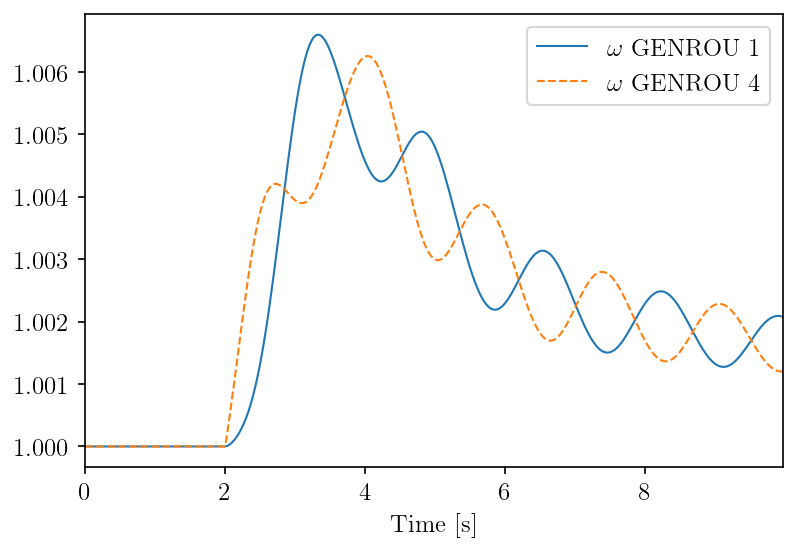

(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbef6913ac8>)

In [11]:
ss.TDS.plt.plot(ss.GENROU.omega, a=(0, 3))

### Y-axis label

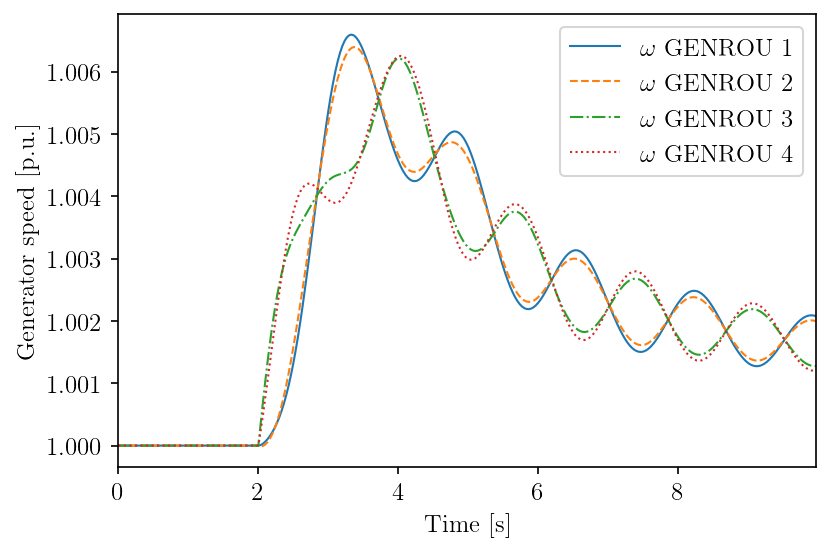

In [16]:
fig, ax = ss.TDS.plotter.plot((5, 6, 7, 8), ylabel='Generator speed [p.u.]')

### Scaling

A lambda functino can be passed to `ycalc` to scale the value. To scale the frequency from per unit to 60 Hz nominal values, use

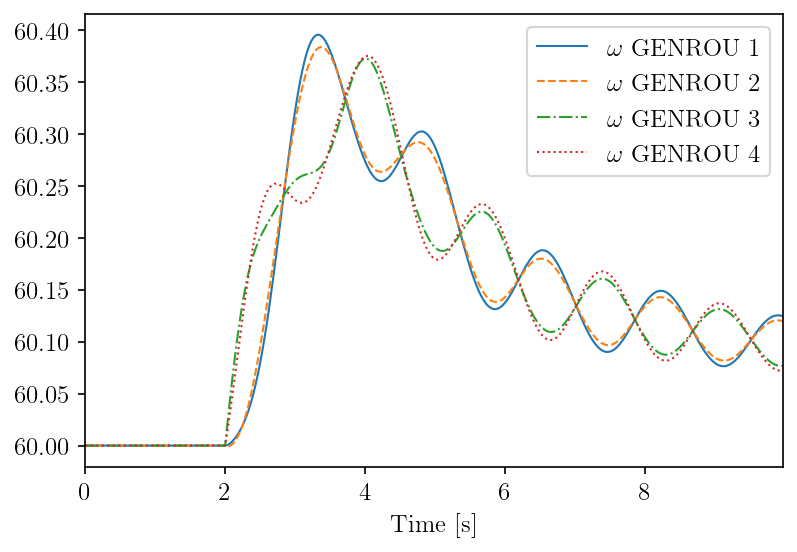

In [17]:
fig, ax = ss.TDS.plotter.plot((5, 6, 7, 8), ycalc=lambda x: 60 * x)

### Greyscale and Grid

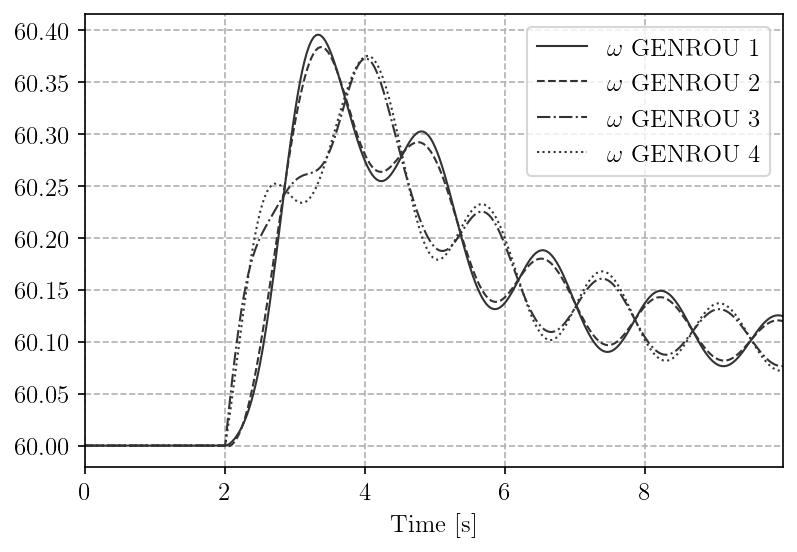

In [18]:
fig, ax = ss.TDS.plotter.plot((5, 6, 7, 8),
                              ycalc=lambda x: 60 * x,
                              greyscale=True,
                              grid=True)

### Save figure

Pass `savefig = True` to save the figure to a `png` file. 

Figure saved to "kundur_full_out_1.png".


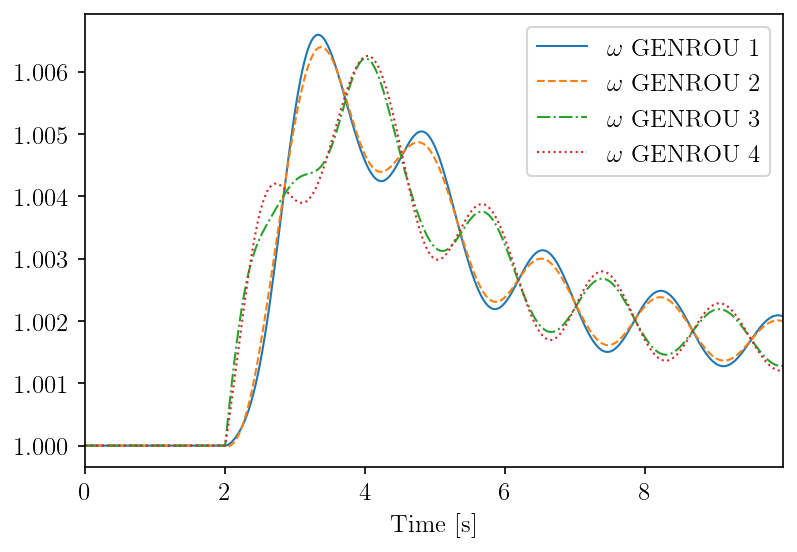

In [19]:
fig, ax = ss.TDS.plotter.plot((5, 6, 7, 8), savefig=True)

### Additional arguments

`plotter.plot` takes addition arguments. To check additional arguments, please use `help` or refer to the source code.

In [12]:
help(ss.TDS.plotter.plot)

Help on method plot in module andes.plot:

plot(yidx, xidx=(0,), a=None, ycalc=None, left=None, right=None, ymin=None, ymax=None, ytimes=None, xlabel=None, ylabel=None, legend=True, grid=False, greyscale=False, latex=True, dpi=150, line_width=1.0, font_size=12, savefig=None, save_format=None, show=True, use_bqplot=False, latex_warn=True, **kwargs) method of andes.plot.TDSData instance
    Entery function for plot scripting. This function retrieves the x and y values based
    on the `xidx` and `yidx` inputs and then calls `plot_data()` to do the actual plotting.
    
    Note that `ytimes` and `ycalc` are applied sequentially if apply.
    
    Refer to `plot_data()` for the definition of arguments.
    
    Parameters
    ----------
    xidx : list or int
        The index for the x-axis variable
    
    yidx : list or int
        The indices for the y-axis variables
    
    Returns
    -------
    (fig, ax)
        Figure and axis handles



In [13]:
help(ss.TDS.plotter.plot_data)

Help on method plot_data in module andes.plot:

plot_data(xdata, ydata, xheader=None, yheader=None, xlabel=None, ylabel=None, line_styles=None, left=None, right=None, ymin=None, ymax=None, legend=True, grid=False, fig=None, ax=None, latex=True, dpi=150, line_width=1.0, font_size=12, greyscale=False, savefig=None, save_format=None, show=True, latex_warn=True, **kwargs) method of andes.plot.TDSData instance
    Plot lines for the supplied data and options. This functions takes `xdata` and `ydata` values. If
    you provide variable indices instead of values, use `plot()`.
    
    Parameters
    ----------
    xdata : array-like
        An array-like object containing the values for the x-axis variable
    
    ydata : array
        An array containing the values of each variables for the y-axis variable. The row
        of `ydata` must match the row of `xdata`. Each column correspondings to a variable.
    
    xheader : list
        A list containing the variable names for the x-axis v

## Cleanup

In [14]:
! andes misc -C


    _           _         | Version 0.9.2.post1+g7283d31e
   /_\  _ _  __| |___ ___ | Python 3.7.1 on Darwin, 05/04/2020 10:21:20 PM
  / _ \| ' \/ _` / -_|_-< | 
 /_/ \_\_||_\__,_\___/__/ | This program comes with ABSOLUTELY NO WARRANTY.

<kundur_full_out.txt> removed.
<kundur_full_out.npy> removed.
<kundur_full_out.lst> removed.


In [21]:
!rm kundur_full_out_1.png